In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import xgboost as xgb

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-7453562e591d>:13: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
matches = pd.read_csv("/content/ODI.csv")

In [3]:
matches=matches.drop(['Unnamed: 0'], axis=1)
matches.shape

(4578, 6)

In [4]:
matches.describe()

,Team_1,Team_2,Winner,Margin,Ground,Match Date
count,4578,4578,4578,4578,4578,4578
unique,28,28,30,239,188,3903
top,Australia,West Indies,Australia,7 wickets,Sharjah,"Feb 4, 2007"
freq,619,562,594,393,244,6


In [5]:
x=matches.loc[matches['Winner']=='no result'].index
matches=matches.drop(x,axis=0)
matches=matches.reset_index(drop=True)

In [6]:
year=[]
for i in matches['Match Date']:
  sp= i.split(", ")
  year.append(sp[1])
matches['Year']=year
matches=matches.drop(['Match Date'],axis=1)

In [7]:
y=matches.loc[matches.Year<'2010'].index
matches=matches.drop(y,axis=0)
matches=matches.reset_index(drop=True)

In [8]:
teams=['Australia', 'England', 'New Zealand','Sri Lanka' ,'Pakistan',
 'India','Bangladesh' ,'South Africa' ,'Afghanistan','Netherlands']
notTeams=[]
for i in range(0,len(matches)):
    if(not (matches.loc[i,"Team_1"] in teams) or (not (matches.loc[i,"Team_2"] in teams))):
        notTeams.append(i)
matches = matches.drop(notTeams)
matches

,Team_1,Team_2,Winner,Margin,Ground,Year
0,Bangladesh,Sri Lanka,Sri Lanka,7 wickets,Mirpur,2010
1,India,Sri Lanka,Sri Lanka,5 wickets,Mirpur,2010
2,Bangladesh,India,India,6 wickets,Mirpur,2010
3,Bangladesh,Sri Lanka,Sri Lanka,9 wickets,Mirpur,2010
4,India,Sri Lanka,India,8 wickets,Mirpur,2010
...,...,...,...,...,...,...
1574,Pakistan,New Zealand,Pakistan,5 wickets,Rawalpindi,2023
1576,Pakistan,New Zealand,Pakistan,7 wickets,Rawalpindi,2023
1578,Pakistan,New Zealand,Pakistan,26 runs,Karachi,2023
1579,Pakistan,New Zealand,Pakistan,102 runs,Karachi,2023


In [9]:
matches=matches.reset_index(drop=True)

In [10]:
wr = np.zeros((10,10))
for i in range(0,10):
    for j in range(0,10):
        if(not (i == j)):
            iwin = 0
            jwin = 0
            for index, row in matches.iterrows():
                if((row['Team_1'] == teams[i] and row['Team_2'] == teams[j]) or
                   (row["Team_2"] == teams[i] and row["Team_1"] == teams[j])):
                    if(row["Winner"] == teams[i]):
                        iwin+=int(row["Year"]) - 2009
                    if(row["Winner"] == teams[j]):
                        jwin+=int(row["Year"]) - 2009
            if(iwin + jwin > 0):
                wr[i][j] = round(100 * iwin/(iwin + jwin),2)
            else:
                wr[i][j] = -10.00
        else:
            wr[i][j] = -10.00

WinRates = pd.DataFrame(wr, index = teams, columns=teams)
WinRates = WinRates.replace(-10,'-')
WinRates

,Australia,England,New Zealand,Sri Lanka,Pakistan,India,Bangladesh,South Africa,Afghanistan,Netherlands
Australia,-,51.9,72.26,55.29,77.84,51.88,100.0,27.27,100.0,-
England,48.1,-,62.2,56.65,80.59,44.23,68.42,50.85,100.0,100.0
New Zealand,27.74,37.8,-,77.64,57.66,46.58,78.08,44.86,100.0,100.0
Sri Lanka,44.71,43.35,22.36,-,30.41,20.0,63.92,28.16,60.71,-
Pakistan,22.16,19.41,42.34,69.59,-,26.32,50.91,52.63,100.0,100.0
India,48.12,55.77,53.42,80.0,73.68,-,66.39,54.93,100.0,100.0
Bangladesh,0.0,31.58,21.92,36.08,49.09,33.61,-,51.61,65.66,66.67
South Africa,72.73,49.15,55.14,71.84,47.37,45.07,48.39,-,100.0,100.0
Afghanistan,0.0,0.0,0.0,39.29,0.0,0.0,34.34,0.0,-,93.62
Netherlands,-,0.0,0.0,-,0.0,0.0,33.33,0.0,6.38,-


In [11]:
matches.head()

,Team_1,Team_2,Winner,Margin,Ground,Year
0,Bangladesh,Sri Lanka,Sri Lanka,7 wickets,Mirpur,2010
1,India,Sri Lanka,Sri Lanka,5 wickets,Mirpur,2010
2,Bangladesh,India,India,6 wickets,Mirpur,2010
3,Bangladesh,Sri Lanka,Sri Lanka,9 wickets,Mirpur,2010
4,India,Sri Lanka,India,8 wickets,Mirpur,2010


In [12]:
winrates = []
for index, row in matches.iterrows():
    Team_1 = row["Team_1"]
    Team_2 = row["Team_2"]
    count1 = 0
    count2 = 0
    for i in range(0,len(matches)):
        if((matches["Team_1"][i] == Team_1 and matches["Team_2"][i] == Team_2)
          or (matches["Team_1"][i] == Team_2 and matches["Team_2"][i] == Team_1)):
            if(matches["Winner"][i] == Team_1):
                count1 += int(matches["Year"][i]) - 2009
            else:
                count2 += int(matches["Year"][i]) - 2009
    if(count1 + count2 > 0):
        winrates.append(round(count1/(count1+count2),2))
    else:
        winrates.append(0.50)
matches["WinRateVsTeam"] = winrates

In [13]:
winratesT1 = []
winratesT2=[]
for index, row in matches.iterrows():
    Team_1 = row["Team_1"]
    Team_2 = row["Team_2"]
    count1_t1 = 0
    count2_t1= 0
    count1_t2 = 0
    count2_t2= 0
    for i in range(0,len(matches)):
      if(matches["Team_1"][i] == Team_1  or matches["Team_2"][i] == Team_1):
            if(matches["Winner"][i] == Team_1):
                count1_t1 += int(matches["Year"][i]) - 2009
            else:
                count2_t1 += int(matches["Year"][i]) - 2009
      if(matches["Team_1"][i] == Team_2  or matches["Team_2"][i] == Team_2):
            if(matches["Winner"][i] == Team_2):
                count1_t2 += int(matches["Year"][i]) - 2009
            else:
                count2_t2 += int(matches["Year"][i]) - 2009

    if(count1_t1 + count2_t1 > 0):
        winratesT1.append(round(count1_t1/(count1_t1+count2_t1),2))
    else:
        winratesT1.append(0.50)


    if(count1_t2 + count2_t2 > 0):
        winratesT2.append(round(count1_t2/(count1_t2+count2_t2),2))
    else:
        winratesT2.append(0.50)



matches["Team_1_WR"] = winratesT1
matches["Team_2_WR"] = winratesT2

In [14]:
matches

,Team_1,Team_2,Winner,Margin,Ground,Year,WinRateVsTeam,Team_1_WR,Team_2_WR
0,Bangladesh,Sri Lanka,Sri Lanka,7 wickets,Mirpur,2010,0.36,0.38,0.35
1,India,Sri Lanka,Sri Lanka,5 wickets,Mirpur,2010,0.79,0.59,0.35
2,Bangladesh,India,India,6 wickets,Mirpur,2010,0.34,0.38,0.59
3,Bangladesh,Sri Lanka,Sri Lanka,9 wickets,Mirpur,2010,0.36,0.38,0.35
4,India,Sri Lanka,India,8 wickets,Mirpur,2010,0.79,0.59,0.35
...,...,...,...,...,...,...,...,...,...
796,Pakistan,New Zealand,Pakistan,5 wickets,Rawalpindi,2023,0.42,0.44,0.55
797,Pakistan,New Zealand,Pakistan,7 wickets,Rawalpindi,2023,0.42,0.44,0.55
798,Pakistan,New Zealand,Pakistan,26 runs,Karachi,2023,0.42,0.44,0.55
799,Pakistan,New Zealand,Pakistan,102 runs,Karachi,2023,0.42,0.44,0.55


In [15]:
# ground=pd.read_csv('/content/ground_info.csv')

In [16]:
d=matches.loc[matches.Winner=='tied'].index
matches=matches.drop(d,axis=0)
matches=matches.reset_index(drop=True)
final=matches

In [17]:
# afghan=pd.read_csv('/content/afghan_grounds.csv')
# aus=pd.read_csv('/content/aus_grounds.csv')
# bangla=pd.read_csv('/content/bangladesh_grounds.csv')
# eng=pd.read_csv('/content/eng_grounds.csv')
# ind=pd.read_csv('/content/india_grounds.csv')
# ne=pd.read_csv('/content/netherlands_grounds.csv')
# nz=pd.read_csv('/content/nz_grounds.csv')
# pak=pd.read_csv('/content/pak_grounds.csv')
# sa=pd.read_csv('/content/sa_grounds.csv')
# sl=pd.read_csv('/content/sl_grounds.csv')


In [18]:
wtype=[]
for i in matches['Margin']:
  sp= i.split(" ")
  #if wickets then 1
  #if runs then 0
  if sp[1]=='wickets':
    wtype.append(1)
  else:
    wtype.append(0)
matches['WinByWickets']=wtype

In [19]:
margin = []
for index,row in matches.iterrows():
    if(not isinstance(row["Margin"],float)):
        margin.append(row["Margin"].split()[0])
    else:
        margin.append(0)
matches["Margin"] = margin

In [20]:
match_pred=matches.copy()

In [21]:

# for k in l:
#   match_pred[k]=np.zeros(len(match_pred['Ground']))

# for i in range(0,len(match_pred)):
#   for j in range(0,len(ground)):
#     if match_pred['Ground'][i] in ground['Name'][j]:
#       match_pred['Ground'][i]=ground['Name'][j]
#       for k in l:
#         match_pred[k][i]=ground[k][j]


In [22]:
i=0
for index,row in match_pred.iterrows():
    if(row["Winner"] == row["Team_1"]):
        match_pred["Winner"][i] = 0
    elif(row["Winner"] == row["Team_2"]):
        match_pred["Winner"][i] = 1
    i+=1

In [23]:
match_pred = match_pred.drop("Margin",axis="columns")
match_pred=match_pred.drop("WinByWickets",axis="columns")

In [24]:
#stats for each team
teamData = pd.read_csv("/content/Team_Stats.csv")
teamData=teamData.drop(['Unnamed: 0'],axis=1)
teamData.columns

Index(['Team', 'MatPlayed', 'High_inns_score', 'NO', 'BatAvg', 'Bat_SR',
       'Runs/Inns', 'BF/Inns', 'Hundreds/Inns', 'Fifties/Inns',
       'Boundries/Inns', 'Sixes/Inns', 'FieldingDiss/Inns', 'Stumping',
       'BallAvg', 'Ball_SR', 'Econ', 'RunsConceded/Inns', 'WickTaken/Inns'],
      dtype='object')

In [25]:
teamIndices = ['India', 'Sri Lanka', 'Bangladesh', 'New Zealand', 'South Africa', 'Pakistan', 'Australia', 'England', 'Netherlands', 'Afghanistan']
stats=['MatPlayed', 'High_inns_score', 'NO', 'BatAvg', 'Bat_SR',
       'Runs/Inns', 'BF/Inns', 'Hundreds/Inns', 'Fifties/Inns',
       'Boundries/Inns', 'Sixes/Inns', 'FieldingDiss/Inns', 'Stumping',
       'BallAvg', 'Ball_SR', 'Econ', 'RunsConceded/Inns', 'WickTaken/Inns']
i = 1
for stat in stats:
    arr = []
    for index,row in match_pred.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team_2"])][i])
    i+=1
    match_pred[stat + '2'] = arr

i = 1
for stat in stats:
    arr = []
    for index,row in match_pred.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team_1"])][i])
    i+=1
    match_pred[stat + '1'] = arr

In [26]:
pmatch=match_pred.copy()
T1 = []
T2 = []
for index,row in pmatch.iterrows():
    T1.append(teamIndices.index(row["Team_1"]))
    T2.append(teamIndices.index(row["Team_2"]))
pmatch["Team_1"] = T1
pmatch["Team_2"] = T2

In [28]:
import sweetviz as sv

my_report = sv.analyze(pmatch)
my_report

                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
# from sklearn import preprocessing

# le = preprocessing.LabelEncoder()
# pmatch['Ground']= le.fit_transform(pmatch['Ground'])

In [34]:
co=pmatch.copy()
co.drop(['Ground','Year'],axis=1,inplace=True)
co['Winner']=pmatch['Winner'].astype('int')


In [ ]:
my_report = sv.analyze([co,"Match"],target_feat='Winner')
my_report.show_notebook()

In [ ]:
my_report.show_html()

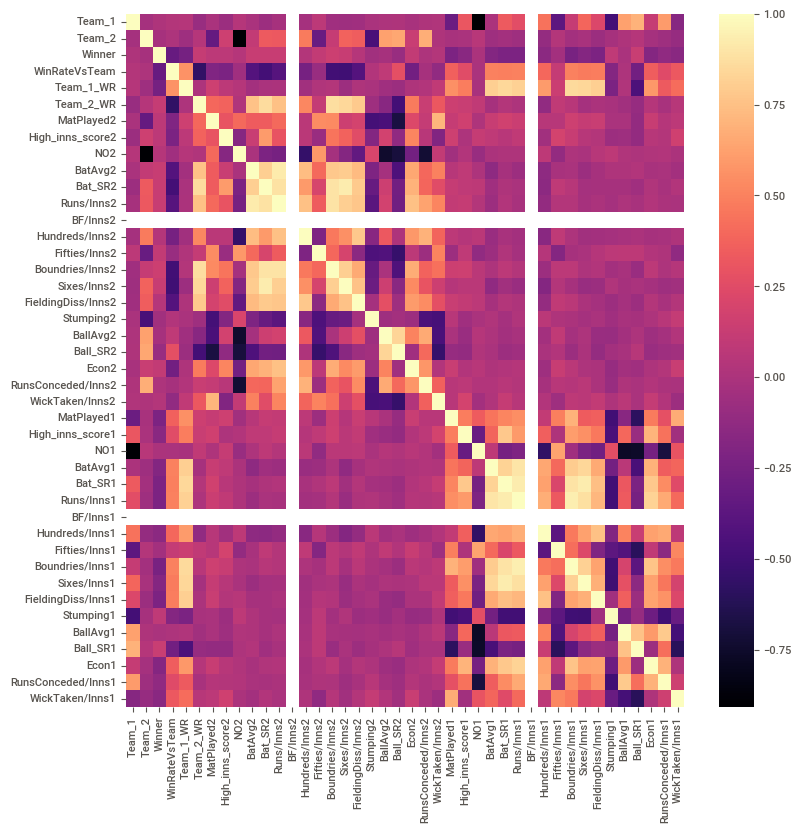

In [45]:
plt.figure(figsize=(9,9))
corr=co.corr()
sns.heatmap(corr,cmap='magma')
plt.show()

In [49]:
corr=co.corr()
corr.Winner.sort_values(ascending=False)

Winner                1.000000
Boundries/Inns2       0.146298
Ball_SR1              0.131159
Bat_SR2               0.127142
Runs/Inns2            0.122784
BatAvg2               0.122245
Sixes/Inns2           0.121817
Team_2_WR             0.114843
Fifties/Inns2         0.105308
Econ2                 0.100928
Stumping1             0.083781
High_inns_score2      0.072858
MatPlayed2            0.069838
FieldingDiss/Inns2    0.042613
NO2                   0.040758
WickTaken/Inns2       0.036188
Hundreds/Inns2        0.035811
Team_1                0.010323
RunsConceded/Inns2    0.004778
NO1                  -0.001007
BallAvg1             -0.009979
Team_2               -0.021071
BallAvg2             -0.027086
Fifties/Inns1        -0.039639
Stumping2            -0.049452
Ball_SR2             -0.095082
RunsConceded/Inns1   -0.125857
Hundreds/Inns1       -0.149131
WickTaken/Inns1      -0.155038
High_inns_score1     -0.155537
Econ1                -0.178083
Sixes/Inns1          -0.182120
BatAvg1 

In [ ]:
X=pmatch.drop(['Winner','Ground'],axis=1)
X['Year']=X['Year'].astype('int')
y=pmatch['Winner'].astype('int')

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=2)

In [ ]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=0)
x_train,y_train=sm.fit_resample(x_train,y_train)
print(y_train.value_counts())

In [67]:
xg_reg1 = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.001, max_depth = 15,
                          alpha = 0.4, n_estimators = 100, subsample = 1, min_child_weight = 2.15, gamma = 0.9)
xg_reg1.fit(x_train,y_train)
preds = xg_reg1.predict(x_test)
error = roc_auc_score(y_test,preds)

for i in range(0,len(preds)):
    if (preds[i]>0.5):
        preds[i]=1
    else:
        preds[i]=0

print('ROC_AUC_Score',error)

ROC_AUC_Score 0.7281947261663287


In [65]:
preds = xg_reg1.predict(X)
error = roc_auc_score(y,preds)


for i in range(0,len(preds)):
    if (preds[i]>0.5):
        preds[i]=1
    else:
        preds[i]=0
print('Classification Report\n',classification_report(preds,y))

Classification Report
               precision    recall  f1-score   support

         0.0       0.76      0.76      0.76       487
         1.0       0.62      0.62      0.62       307

    accuracy                           0.71       794
   macro avg       0.69      0.69      0.69       794
weighted avg       0.71      0.71      0.71       794



In [114]:
margin=matches.copy()
margin=margin.drop(['Ground'],axis=1)

In [115]:
# l=['ground_Mat', 'ground_NO', 'ground_Runs',
#        'ground_Bat_Ave','ground_Bat_SR', 'ground_Runs_Conceded',
#        'ground_Wkts', 'ground_Ball_Ave', 'ground_Econ', 'ground_Ball_SR']
# for k in l:
#   margin[k]=np.zeros(len(margin['Ground']))

# for i in range(0,len(margin)):
#   for j in range(0,len(ground)):
#     if margin['Ground'][i] in ground['Name'][j]:
#       margin['Ground'][i]=ground['Name'][j]
#       for k in l:
#         margin[k][i]=ground[k][j]

In [116]:
margin0=margin.loc[margin['WinByWickets']==0]
margin1=margin.loc[margin['WinByWickets']==1]

In [117]:
i = 1
for stat in stats:
    arr = []
    for index,row in margin0.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team_2"])][i])
    i+=1
    margin0[stat + '2'] = arr

i = 1
for stat in stats:
    arr = []
    for index,row in margin0.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team_1"])][i])
    i+=1
    margin0[stat + '1'] = arr

i = 1
for stat in stats:
    arr = []
    for index,row in margin1.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team_2"])][i])
    i+=1
    margin1[stat + '2'] = arr

i = 1
for stat in stats:
    arr = []
    for index,row in margin1.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team_1"])][i])
    i+=1
    margin1[stat + '1'] = arr

In [118]:
# from sklearn import preprocessing

# le = preprocessing.LabelEncoder()
# margin0['Ground']= le.fit_transform(margin0['Ground'])
# margin1['Ground']= le.fit_transform(margin1['Ground'])

In [119]:
T1_0 = []
T2_0 = []
Winner_0 = []
for index,row in margin0.iterrows():
    T1_0.append(teamIndices.index(row["Team_1"]))
    T2_0.append(teamIndices.index(row["Team_2"]))
    Winner_0.append(teamIndices.index(row["Winner"]))
margin0["Team_1"] = T1_0
margin0["Team_2"] = T2_0
margin0["Winner"] = Winner_0

marginMatches0 = margin0.astype("float64")
T1_1 = []
T2_1 = []
Winner_1 = []
for index,row in margin1.iterrows():
    T1_1.append(teamIndices.index(row["Team_1"]))
    T2_1.append(teamIndices.index(row["Team_2"]))
    Winner_1.append(teamIndices.index(row["Winner"]))
margin1["Team_1"] = T1_1
margin1["Team_2"] = T2_1
margin1["Winner"] = Winner_1

marginMatches1 = margin1.astype("float64")

In [130]:
X_0=margin0.drop(['Margin','WinByWickets'],axis=1)
X_0['Year']=X_0['Year'].astype('int')
y_0=margin0['Margin']
from sklearn.model_selection import train_test_split
x_0_train,x_0_test,y_0_train,y_0_test=train_test_split(X_0,y_0,test_size=0.15)

In [148]:
X_1=margin1.drop(['Margin','WinByWickets'],axis=1)
y_1=margin1['Margin']
X_1['Year']=X_1['Year'].astype('int')
from sklearn.model_selection import train_test_split
x_1_train,x_1_test,y_1_train,y_1_test=train_test_split(X_1,y_1,test_size=0.15)

In [203]:
xg_regMarg0= xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.1,
                              learning_rate = 0.0015, max_depth = 6, alpha = 2.5, n_estimators = 19,
                              subsample = 0.95, min_child_weight = 6, gamma = 3)


xg_regMarg0.fit(x_0_train,y_0_train)
predsMarg0 = xg_regMarg0.predict(x_0_test)
error = mean_squared_error(y_0_test,predsMarg0)

print("MSE error = " + str(error))
err = roc_auc_score(y_test,preds)

MSE error = 2740.837122564883


In [174]:

xg_regMarg1 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.74, learning_rate = 0.17,
                               max_depth = 2, alpha = 0.5, n_estimators = 29, subsample = 0.95,
                               min_child_weight = 1, gamma = 0.54)

xg_regMarg1.fit(x_1_train,y_1_train)
predsMarg1 = xg_regMarg1.predict(x_1_test)
error = mean_squared_error(y_1_test,predsMarg1)

print("MSE error = " + str(error))

MSE error = 3.497717020909022


In [ ]:
wc=pd.read_csv('/content/Fixtures.csv')

In [ ]:
wc=wc.drop(['Round_number','Group','Result'],axis=1)

In [ ]:
wc=wc.drop([45,46,47],axis=0)

In [ ]:
WCup=wc.copy()
WCup=WCup.drop(['Date'],axis=1)
WCup["Year"]=2023

In [ ]:
team=[]
for i in WCup['Team_1']:
  sp=i.split(' ')
  if sp[0]=='Pakistan':
    team.append(sp[0])
  else:
    team.append(i)
WCup['Team_1']=team

In [ ]:
winrates = []
for index, row in WCup.iterrows():
    Team_1 = row["Team_1"]
    Team_2 = row["Team_2"]
    count1 = 0
    count2 = 0
    for i in range(0,len(row)):
        if((matches["Team_1"][i] == Team_1 and matches["Team_2"][i] == Team_2)
          or (matches["Team_1"][i] == Team_2 and matches["Team_2"][i] == Team_1)):
            if(matches["Winner"][i] == Team_1):
                count1 += int(matches["Year"][i]) - 2009
            else:
                count2 += int(matches["Year"][i]) - 2009
    if(count1 + count2 > 0):
        winrates.append(round(count1/(count1+count2),2))
    else:
        winrates.append(0.50)
WCup["WinRateVsTeam"] = winrates

In [ ]:
winratesT1 = []
winratesT2=[]
for index, row in WCup.iterrows():
    Team_1 = row["Team_1"]
    Team_2 = row["Team_2"]
    count1_t1 = 0
    count2_t1= 0
    count1_t2 = 0
    count2_t2= 0
    for i in range(0,len(row)):
      if(matches["Team_1"][i] == Team_1  or matches["Team_2"][i] == Team_1):
            if(matches["Winner"][i] == Team_1):
                count1_t1 += int(matches["Year"][i]) - 2009
            else:
                count2_t1 += int(matches["Year"][i]) - 2009
      if(matches["Team_1"][i] == Team_2  or matches["Team_2"][i] == Team_2):
            if(matches["Winner"][i] == Team_2):
                count1_t2 += int(matches["Year"][i]) - 2009
            else:
                count2_t2 += int(matches["Year"][i]) - 2009

    if(count1_t1 + count2_t1 > 0):
        winratesT1.append(round(count1_t1/(count1_t1+count2_t1),2))
    else:
        winratesT1.append(0.50)


    if(count1_t2 + count2_t2 > 0):
        winratesT2.append(round(count1_t2/(count1_t2+count2_t2),2))
    else:
        winratesT2.append(0.50)



WCup["Team_1_WR"] = winratesT1
WCup["Team_2_WR"] = winratesT2

In [ ]:
l=['ground_Mat', 'ground_NO', 'ground_Runs',
       'ground_Bat_Ave','ground_Bat_SR', 'ground_Runs_Conceded',
       'ground_Wkts', 'ground_Ball_Ave', 'ground_Econ', 'ground_Ball_SR']
for k in l:
  WCup[k]=np.zeros(len(WCup['Location']))

for i in range(0,len(WCup)):
  for j in range(0,len(ground)):
    if WCup['Location'][i] in ground['Name'][j]:
      WCup['Location'][i]=ground['Name'][j]
      for k in l:
        WCup[k][i]=ground[k][j]

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
WCup['Location']= le.fit_transform(WCup['Location'])

In [ ]:
i = 1
for stat in stats:
    arr = []
    for index,row in WCup.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team_2"])][i])
    i+=1
    WCup[stat + '2'] = arr
i = 1
for stat in stats:
    arr = []
    for index,row in WCup.iterrows():
        arr.append(teamData.loc[teamIndices.index(row["Team_1"])][i])
    i+=1
    WCup[stat + '1'] = arr

In [ ]:
pmatch=WCup.copy()
T1 = []
T2 = []
for index,row in pmatch.iterrows():
    T1.append(teamIndices.index(row["Team_1"]))
    T2.append(teamIndices.index(row["Team_2"]))
pmatch["Team_1"] = T1
pmatch["Team_2"] = T2

In [ ]:
pmatch=pmatch.rename(columns = {'Location':'Ground'})

In [ ]:
preds = xg_reg1.predict(pmatch)

for i in range(0,len(preds)):
    if (preds[i]>0.5):
        preds[i]=1
    else:
        preds[i]=0

In [ ]:
preds

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
pmatch.insert(2,'Winner',preds)

In [ ]:

predsMarg1 = xg_regMarg1.predict(pmatch)
predsMarg0 = xg_regMarg0.predict(pmatch)

In [ ]:
wc['Winner']=preds
wc['Winner Run Margin']=predsMarg0
wc['Winner Wicket Margin']=predsMarg1

In [ ]:
for i in range(0,len(wc)):
  if wc['Winner'][i]== 0.0:
    wc["Winner"][i]=wc["Team_1"][i]
  else:
    wc["Winner"][i]=wc["Team_2"][i]

In [ ]:
for i in range(0,len(wc)):
  wc['Winner Run Margin'][i]=str(round(wc['Winner Run Margin'][i])) +' Runs'
  wc['Winner Wicket Margin'][i]=str(round(wc['Winner Wicket Margin'][i]))+' Wickets'

In [ ]:
wc

,Team_1,Team_2,Date,Location,Winner,Winner Run Margin,Winner Wicket Margin
0,England,New Zealand,5/10/2023,"Narendra Modi Stadium, Ahmedabad",England,64 Runs,6 Wickets
1,Pakistan,Netherlands,6/10/2023,"Rajiv Gandhi International Stadium, Hyderabad",Pakistan,76 Runs,6 Wickets
2,Bangladesh,Afghanistan,7/10/2023,"Himachal Pradesh Cricket Association Stadium, ...",Bangladesh,88 Runs,5 Wickets
3,South Africa,Sri Lanka,7/10/2023,"Arun Jaitley Stadium, Delhi",South Africa,102 Runs,6 Wickets
4,India,Australia,8/10/2023,"MA Chidambaram Stadium, Chennai",India,80 Runs,6 Wickets
5,New Zealand,Netherlands,9/10/2023,"Rajiv Gandhi International Stadium, Hyderabad",New Zealand,94 Runs,7 Wickets
6,England,Bangladesh,10/10/2023,"Himachal Pradesh Cricket Association Stadium, ...",England,91 Runs,7 Wickets
7,India,Afghanistan,11/10/2023,"Arun Jaitley Stadium, Delhi",India,105 Runs,6 Wickets
8,Pakistan,Sri Lanka,12/10/2023,"Rajiv Gandhi International Stadium, Hyderabad",Pakistan,76 Runs,6 Wickets
9,Australia,South Africa,13/10/2023,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,South Africa,62 Runs,7 Wickets


In [ ]:
wc.to_csv('ground_pred.csv')